# 01 — Exploratory Data Analysis: Euclid Q1 Morphology Catalog

**Goal**: Understand the Galaxy Zoo Euclid Q1 morphology catalog before building
ViT-based regression models.

**Data source**: [Zenodo #15020547](https://zenodo.org/records/15020547) — Walmsley et al. 2025

**Key questions**:
1. How large is the catalog and what columns does it contain?
2. How does the Galaxy Zoo decision tree create the NaN structure?
3. What is the distribution of vote fractions for each morphology question?
4. How many galaxies pass quality cuts for training?
5. What are the physical property distributions (magnitude, size, ellipticity)?
6. How should we stratify the train/val/test split?

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
PROJECT_ROOT = Path('..').resolve()
CATALOG_PATH = PROJECT_ROOT / 'data' / 'raw' / 'morphology_catalogue.parquet'
FIGURES_DIR = PROJECT_ROOT / 'results' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Catalog path: {CATALOG_PATH}')
print(f'Catalog exists: {CATALOG_PATH.exists()}')

Project root: C:\Users\alexy\Documents\Claude_projects\astrophysics_projects\euclid_q1
Catalog path: C:\Users\alexy\Documents\Claude_projects\astrophysics_projects\euclid_q1\data\raw\morphology_catalogue.parquet
Catalog exists: True


## 2. Load Catalog

In [2]:
df = pd.read_parquet(CATALOG_PATH)
print(f'Shape: {df.shape[0]:,} galaxies x {df.shape[1]} columns')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB')
df.head(3)

Shape: 380,111 galaxies x 74 columns
Memory usage: 737.8 MB


,object_id,right_ascension,declination,segmentation_area,flux_segmentation,flux_detection_total,flux_vis_1fwhm_aper,mumax_minus_mag,mu_max,ellipticity,...,artifact_saturation_fraction,artifact_other_fraction,artifact_ghost_fraction,log_segmentation_area,log_kron_radius,cutout_width_arcsec,warning_galaxy_fails_training_cuts,jpg_loc_gz_arcsinh_vis_y,jpg_loc_gz_arcsinh_vis_only,jpg_loc_gz_arcsinh_vis_lsb
0,-520564092291261106,52.056409,-29.126111,779,14.553082,15.691106,4.477242,-0.194441,20.716425,0.357027,...,NaN,NaN,NaN,2.891537,1.607289,48.011157,True,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...
1,-520560290287655192,52.056029,-28.765519,863,14.087326,15.247946,4.126712,-0.319044,20.622927,0.039894,...,NaN,NaN,NaN,2.936011,1.555568,41.862106,True,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...
2,-520559452289115027,52.055945,-28.911503,1528,20.475792,23.627728,5.388710,-0.667717,19.798729,0.445131,...,NaN,NaN,NaN,3.184123,1.834273,75.189153,False,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...,/media/home/team_workspaces/Euclid-Consortium/...


## 3. Column Inventory

Group the 74 columns by purpose to understand the catalog structure.

In [3]:
# Group columns by purpose
col_groups = {
    'Identifiers': ['object_id', 'id_str', 'tile_index', 'segmentation_map_id'],
    'Position': ['right_ascension', 'declination', 'ra', 'dec'],
    'Physical': ['segmentation_area', 'flux_segmentation', 'flux_detection_total',
                 'flux_vis_1fwhm_aper', 'mumax_minus_mag', 'mu_max', 'ellipticity',
                 'kron_radius', 'mag_segmentation', 'log_segmentation_area',
                 'log_kron_radius', 'cutout_width_arcsec'],
    'File paths': ['vis_loc', 'nir_y_loc', 'jpg_loc_generic',
                   'jpg_loc_gz_arcsinh_vis_y', 'jpg_loc_gz_arcsinh_vis_only',
                   'jpg_loc_gz_arcsinh_vis_lsb'],
    'Metadata': ['release_name', 'warning_galaxy_fails_training_cuts'],
}

# Everything else is morphology vote fractions
known_cols = set()
for cols in col_groups.values():
    known_cols.update(cols)
morph_cols = [c for c in df.columns if c not in known_cols]
col_groups['Morphology fractions'] = morph_cols

for group, cols in col_groups.items():
    print(f'\n--- {group} ({len(cols)} columns) ---')
    for c in cols:
        null_pct = df[c].isnull().mean() * 100
        null_str = f' [{null_pct:.1f}% null]' if null_pct > 0 else ''
        print(f'  {c} ({df[c].dtype}){null_str}')


--- Identifiers (4 columns) ---
  object_id (object)
  id_str (object)
  tile_index (int64)
  segmentation_map_id (int64)

--- Position (4 columns) ---
  right_ascension (float64)
  declination (float64)
  ra (float64)
  dec (float64)

--- Physical (12 columns) ---
  segmentation_area (int64)
  flux_segmentation (float64)
  flux_detection_total (float64)
  flux_vis_1fwhm_aper (float64) [1.4% null]
  mumax_minus_mag (float64) [0.0% null]
  mu_max (float64)
  ellipticity (float64)
  kron_radius (float64)
  mag_segmentation (float64)
  log_segmentation_area (float64)
  log_kron_radius (float64)
  cutout_width_arcsec (float64)

--- File paths (6 columns) ---
  vis_loc (object)
  nir_y_loc (object)
  jpg_loc_generic (object)
  jpg_loc_gz_arcsinh_vis_y (object)
  jpg_loc_gz_arcsinh_vis_only (object)
  jpg_loc_gz_arcsinh_vis_lsb (object)

--- Metadata (2 columns) ---
  release_name (object)
  warning_galaxy_fails_training_cuts (bool)

--- Morphology fractions (46 columns) ---
  smooth-or-fea

## 4. Galaxy Zoo Decision Tree & NaN Structure

The Galaxy Zoo uses a **branching decision tree**: not all galaxies are asked all questions.
- **All galaxies** get: `smooth-or-featured` and `merging`
- **Smooth galaxies** → `how-rounded`
- **Featured galaxies** → `disk-edge-on` → if not edge-on: `has-spiral-arms`, `bar`, `bulge-size`, `clumps`
- **Edge-on galaxies** → `edge-on-bulge`
- **Spiral galaxies** → `spiral-winding`, `spiral-arm-count`
- **Problem galaxies** → `problem` subtypes → if artifact: `artifact` subtypes

This is why downstream questions have progressively more NaNs — they only apply to the subset that reached that branch.

In [4]:
# Map morphology questions to their answer columns
morphology_questions = {
    'smooth-or-featured': ['smooth', 'featured-or-disk', 'problem'],
    'disk-edge-on': ['yes', 'no'],
    'has-spiral-arms': ['yes', 'no'],
    'bar': ['strong', 'weak', 'no'],
    'bulge-size': ['dominant', 'large', 'moderate', 'small', 'none'],
    'how-rounded': ['round', 'in-between', 'cigar-shaped'],
    'edge-on-bulge': ['boxy', 'none', 'rounded'],
    'spiral-winding': ['tight', 'medium', 'loose'],
    'spiral-arm-count': ['1', '2', '3', '4', 'more-than-4', 'cant-tell'],
    'merging': ['none', 'minor-disturbance', 'major-disturbance', 'merger'],
    'clumps': ['yes', 'no'],
    'problem': ['star', 'artifact', 'zoom'],
    'artifact': ['satellite', 'scattered', 'diffraction', 'ray', 'saturation', 'other', 'ghost'],
}

# Sample sizes per question
question_stats = []
for question, answers in morphology_questions.items():
    col = f'{question}_{answers[0]}_fraction'
    n_valid = df[col].notna().sum()
    question_stats.append({
        'Question': question,
        'Answers': len(answers),
        'N valid': n_valid,
        '% of total': n_valid / len(df) * 100,
    })

stats_df = pd.DataFrame(question_stats).sort_values('N valid', ascending=False)
stats_df.style.format({'N valid': '{:,.0f}', '% of total': '{:.1f}%'})

,Question,Answers,N valid,% of total
0,smooth-or-featured,3,"380,111",100.0%
9,merging,4,"380,111",100.0%
5,how-rounded,3,"192,482",50.6%
1,disk-edge-on,2,"124,133",32.7%
2,has-spiral-arms,2,"90,595",23.8%
4,bulge-size,5,"90,595",23.8%
3,bar,3,"90,595",23.8%
10,clumps,2,"90,595",23.8%
7,spiral-winding,3,"51,462",13.5%
8,spiral-arm-count,6,"51,462",13.5%


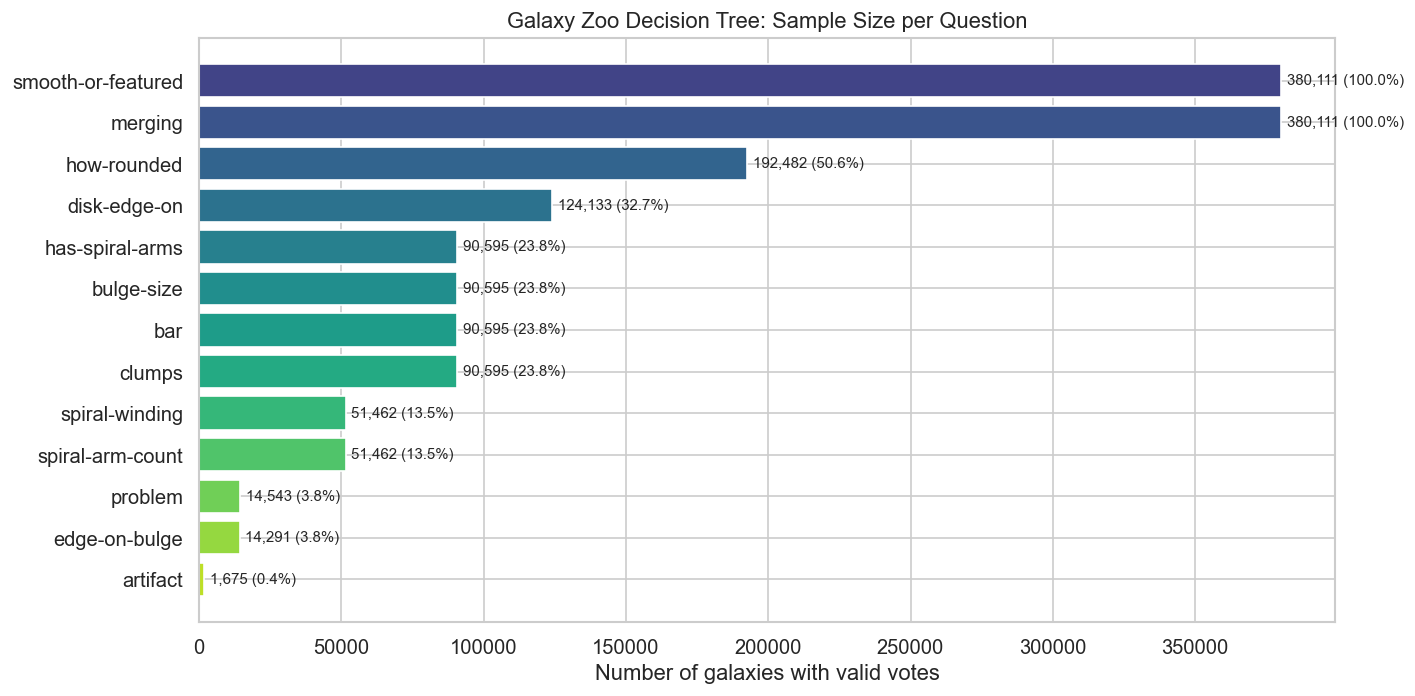

In [5]:
# Visualize the decision tree sample sizes
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(stats_df)))
bars = ax.barh(stats_df['Question'], stats_df['N valid'], color=colors)
ax.set_xlabel('Number of galaxies with valid votes')
ax.set_title('Galaxy Zoo Decision Tree: Sample Size per Question')
ax.invert_yaxis()

for bar, n in zip(bars, stats_df['N valid']):
    ax.text(bar.get_width() + 2000, bar.get_y() + bar.get_height()/2,
            f'{n:,.0f} ({n/len(df)*100:.1f}%)',
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_decision_tree_sample_sizes.pdf', bbox_inches='tight')
plt.show()

## 5. Quality Filter: Training Cuts

The catalog includes a `warning_galaxy_fails_training_cuts` flag. Galaxies that fail these
cuts were deemed too small, too faint, or otherwise unsuitable for reliable morphology predictions.

Total galaxies:       380,111
Fails training:       184,395 (48.5%)
Passes training:      195,716 (51.5%)


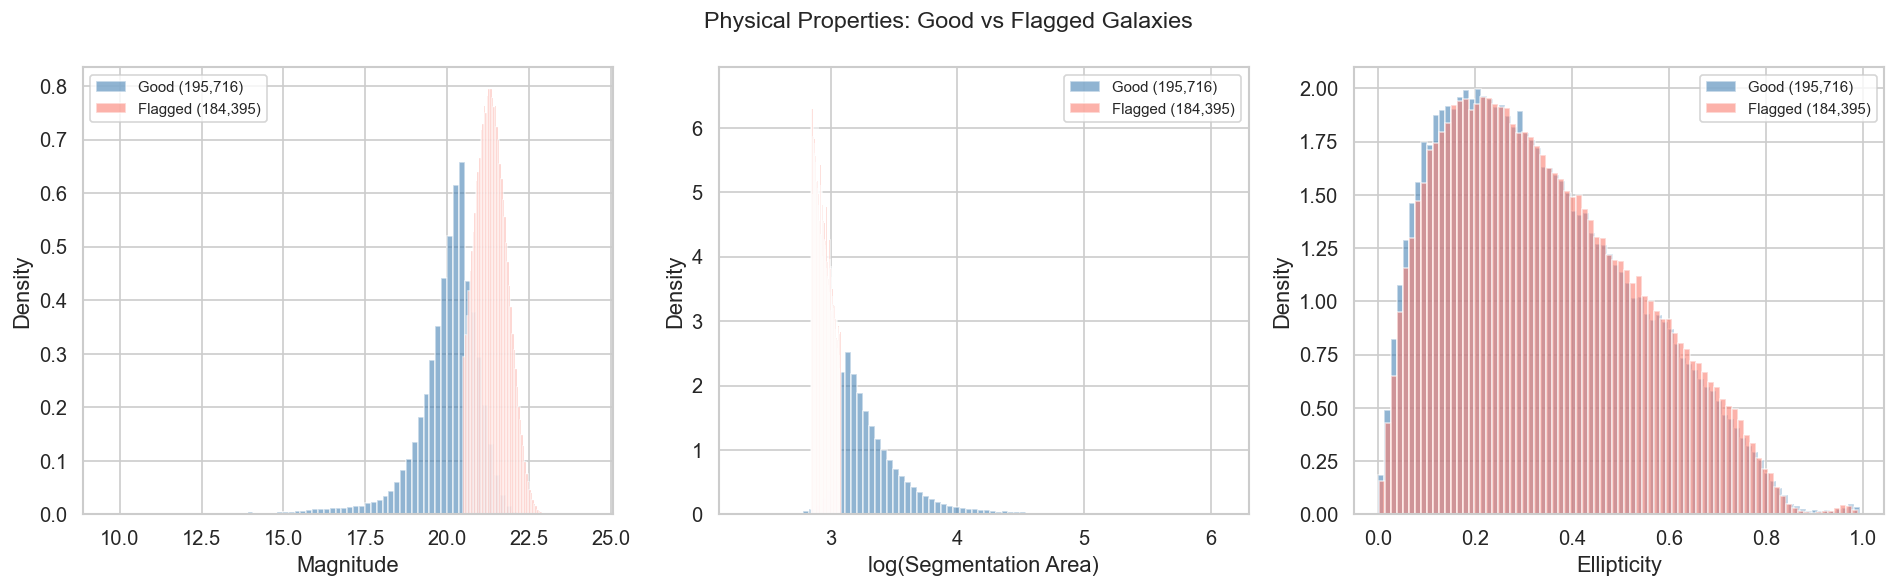

In [6]:
n_total = len(df)
n_flagged = df['warning_galaxy_fails_training_cuts'].sum()
n_good = n_total - n_flagged

print(f'Total galaxies:    {n_total:>10,}')
print(f'Fails training:    {n_flagged:>10,} ({n_flagged/n_total*100:.1f}%)')
print(f'Passes training:   {n_good:>10,} ({n_good/n_total*100:.1f}%)')

# Compare distributions for flagged vs good
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col, label in zip(axes,
    ['mag_segmentation', 'log_segmentation_area', 'ellipticity'],
    ['Magnitude', 'log(Segmentation Area)', 'Ellipticity']):
    
    good = df[~df['warning_galaxy_fails_training_cuts']][col].dropna()
    bad = df[df['warning_galaxy_fails_training_cuts']][col].dropna()
    
    ax.hist(good, bins=80, alpha=0.6, label=f'Good ({len(good):,})', density=True, color='steelblue')
    ax.hist(bad, bins=80, alpha=0.6, label=f'Flagged ({len(bad):,})', density=True, color='salmon')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)

fig.suptitle('Physical Properties: Good vs Flagged Galaxies', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_quality_filter_comparison.pdf', bbox_inches='tight')
plt.show()

In [7]:
# From here on, work with the good galaxies only
df_good = df[~df['warning_galaxy_fails_training_cuts']].copy()
print(f'Working dataset: {len(df_good):,} galaxies')

Working dataset: 195,716 galaxies


## 6. Vote Fraction Distributions

Each morphology question has multiple answer options with vote fractions summing to 1.
We visualize the top-level question (`smooth-or-featured`) and the key sub-questions.

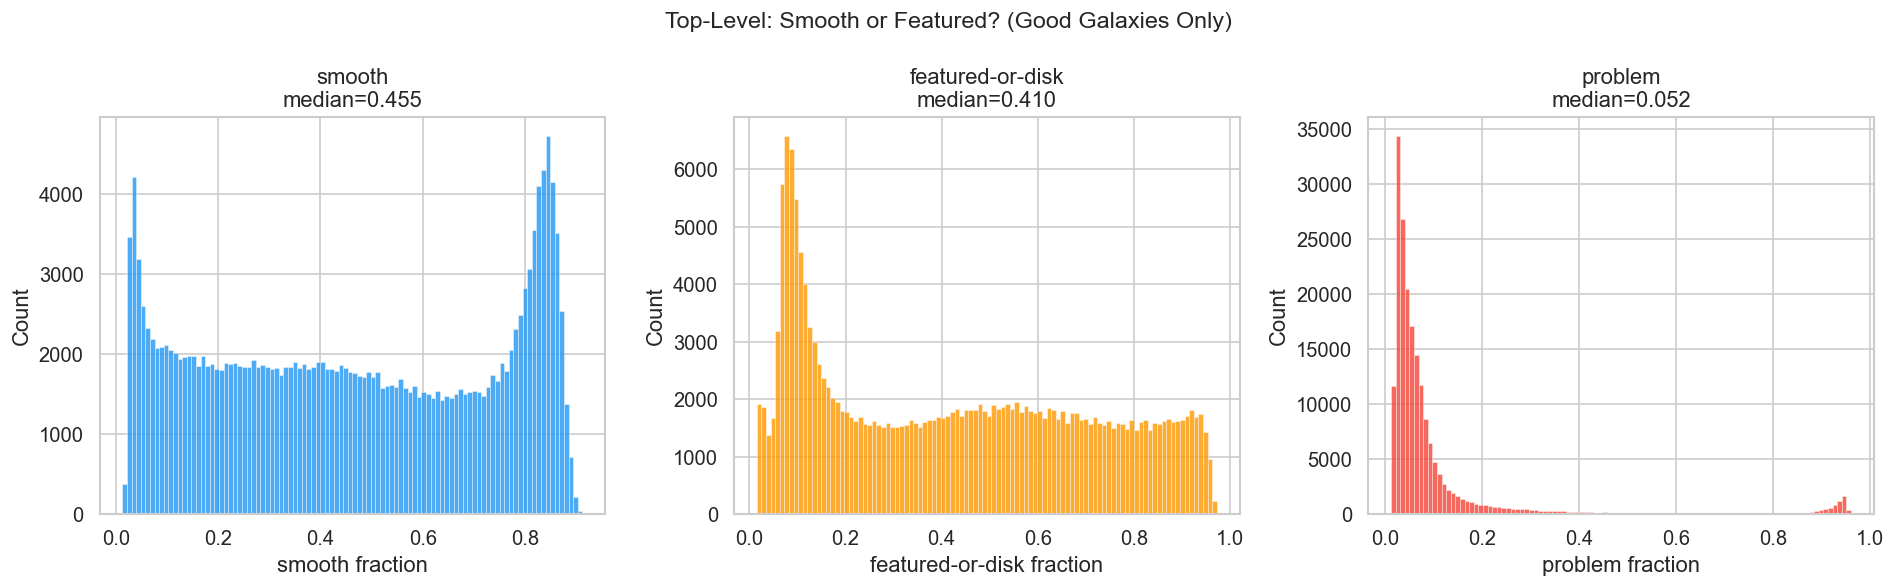

In [8]:
# Top-level: smooth vs featured vs problem
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, answer, color in zip(axes,
    ['smooth', 'featured-or-disk', 'problem'],
    ['#2196F3', '#FF9800', '#F44336']):
    
    col = f'smooth-or-featured_{answer}_fraction'
    ax.hist(df_good[col], bins=100, color=color, alpha=0.8, edgecolor='white', linewidth=0.3)
    ax.set_xlabel(f'{answer} fraction')
    ax.set_ylabel('Count')
    ax.set_title(f'{answer}\nmedian={df_good[col].median():.3f}')

fig.suptitle('Top-Level: Smooth or Featured? (Good Galaxies Only)', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_smooth_featured_distribution.pdf', bbox_inches='tight')
plt.show()

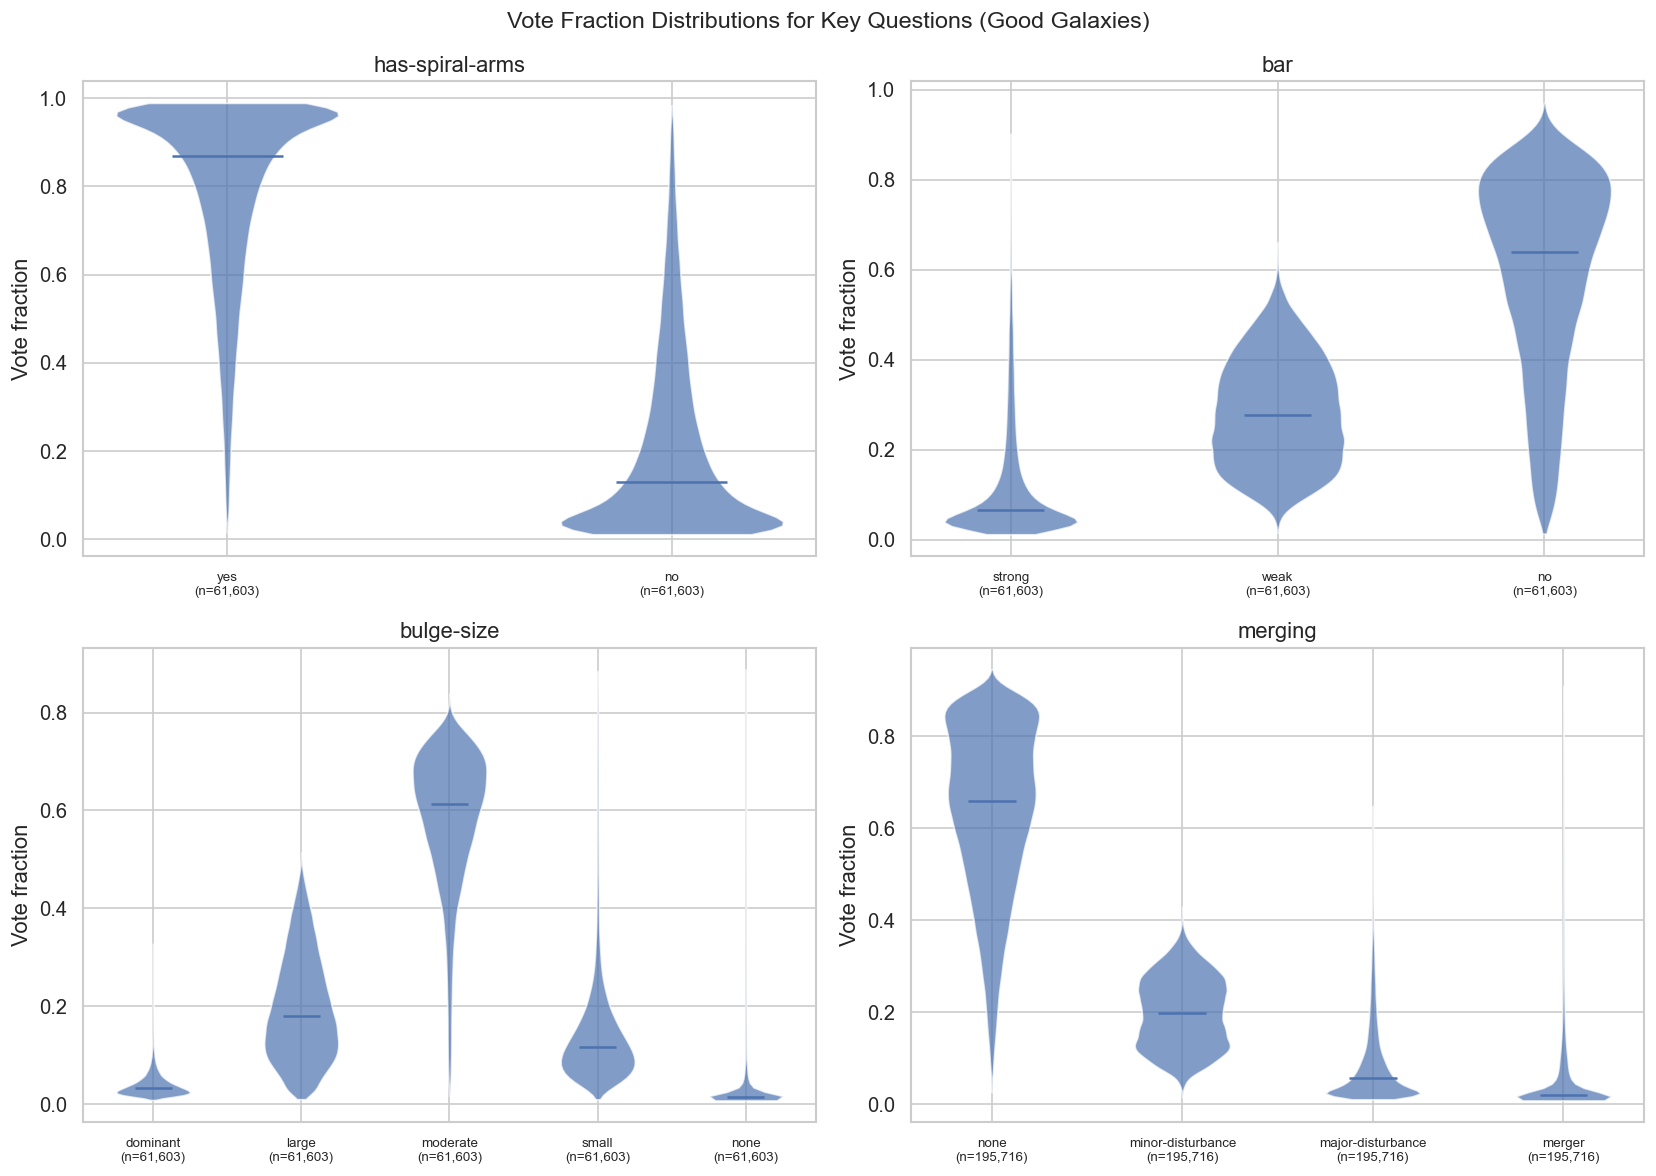

In [9]:
# Key sub-questions for featured galaxies
sub_questions = {
    'has-spiral-arms': ['yes', 'no'],
    'bar': ['strong', 'weak', 'no'],
    'bulge-size': ['dominant', 'large', 'moderate', 'small', 'none'],
    'merging': ['none', 'minor-disturbance', 'major-disturbance', 'merger'],
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (question, answers) in zip(axes.flat, sub_questions.items()):
    data = []
    labels = []
    for answer in answers:
        col = f'{question}_{answer}_fraction'
        vals = df_good[col].dropna()
        if len(vals) > 0:
            data.append(vals)
            labels.append(f'{answer}\n(n={len(vals):,})')
    
    parts = ax.violinplot(data, showmedians=True, showextrema=False)
    for pc in parts['bodies']:
        pc.set_alpha(0.7)
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_ylabel('Vote fraction')
    ax.set_title(question)

fig.suptitle('Vote Fraction Distributions for Key Questions (Good Galaxies)', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_vote_distributions_subquestions.pdf', bbox_inches='tight')
plt.show()

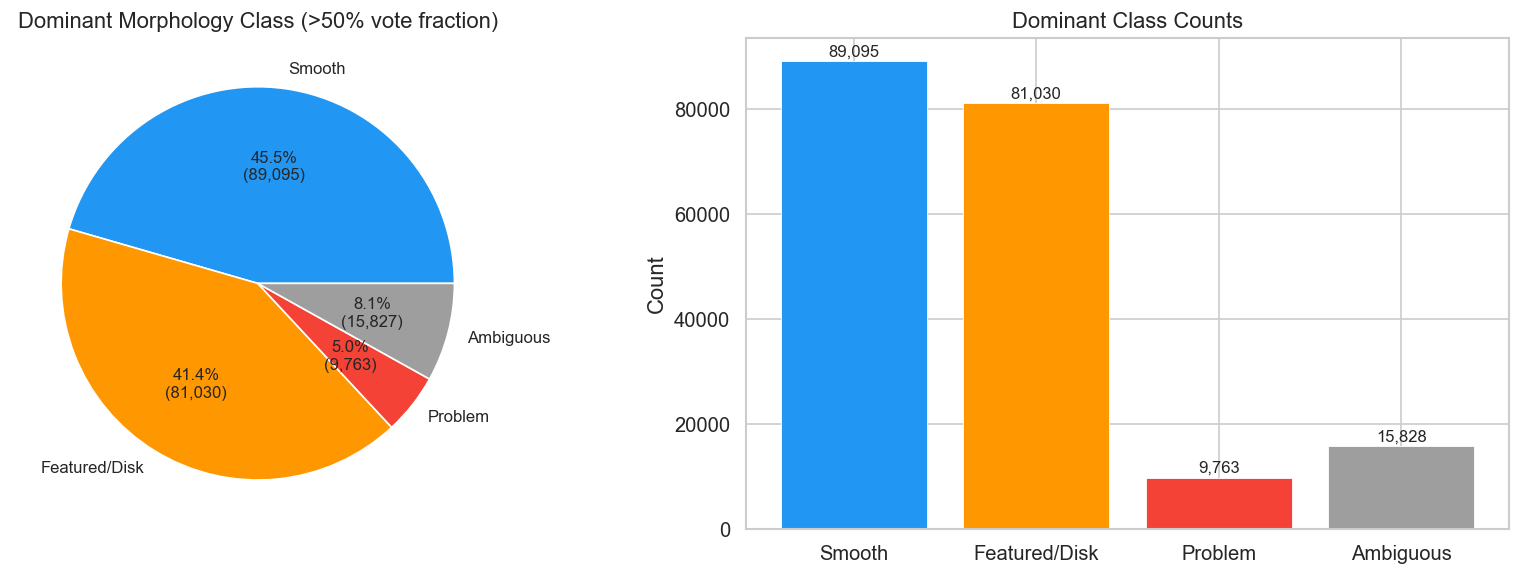

In [10]:
# Dominant class breakdown for the good galaxies
dominant_smooth = (df_good['smooth-or-featured_smooth_fraction'] > 0.5).sum()
dominant_feat = (df_good['smooth-or-featured_featured-or-disk_fraction'] > 0.5).sum()
dominant_prob = (df_good['smooth-or-featured_problem_fraction'] > 0.5).sum()
ambiguous = len(df_good) - dominant_smooth - dominant_feat - dominant_prob

labels = ['Smooth', 'Featured/Disk', 'Problem', 'Ambiguous']
counts = [dominant_smooth, dominant_feat, dominant_prob, ambiguous]
colors = ['#2196F3', '#FF9800', '#F44336', '#9E9E9E']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
wedges, texts, autotexts = ax1.pie(counts, labels=labels, colors=colors,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*len(df_good)):,})',
    textprops={'fontsize': 10})
ax1.set_title('Dominant Morphology Class (>50% vote fraction)')

# Bar chart
ax2.bar(labels, counts, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_ylabel('Count')
ax2.set_title('Dominant Class Counts')
for i, (label, count) in enumerate(zip(labels, counts)):
    ax2.text(i, count + 1000, f'{count:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_dominant_class_breakdown.pdf', bbox_inches='tight')
plt.show()

## 7. Physical Property Distributions

ValueError: supplied range of [12.44183349609375, inf] is not finite

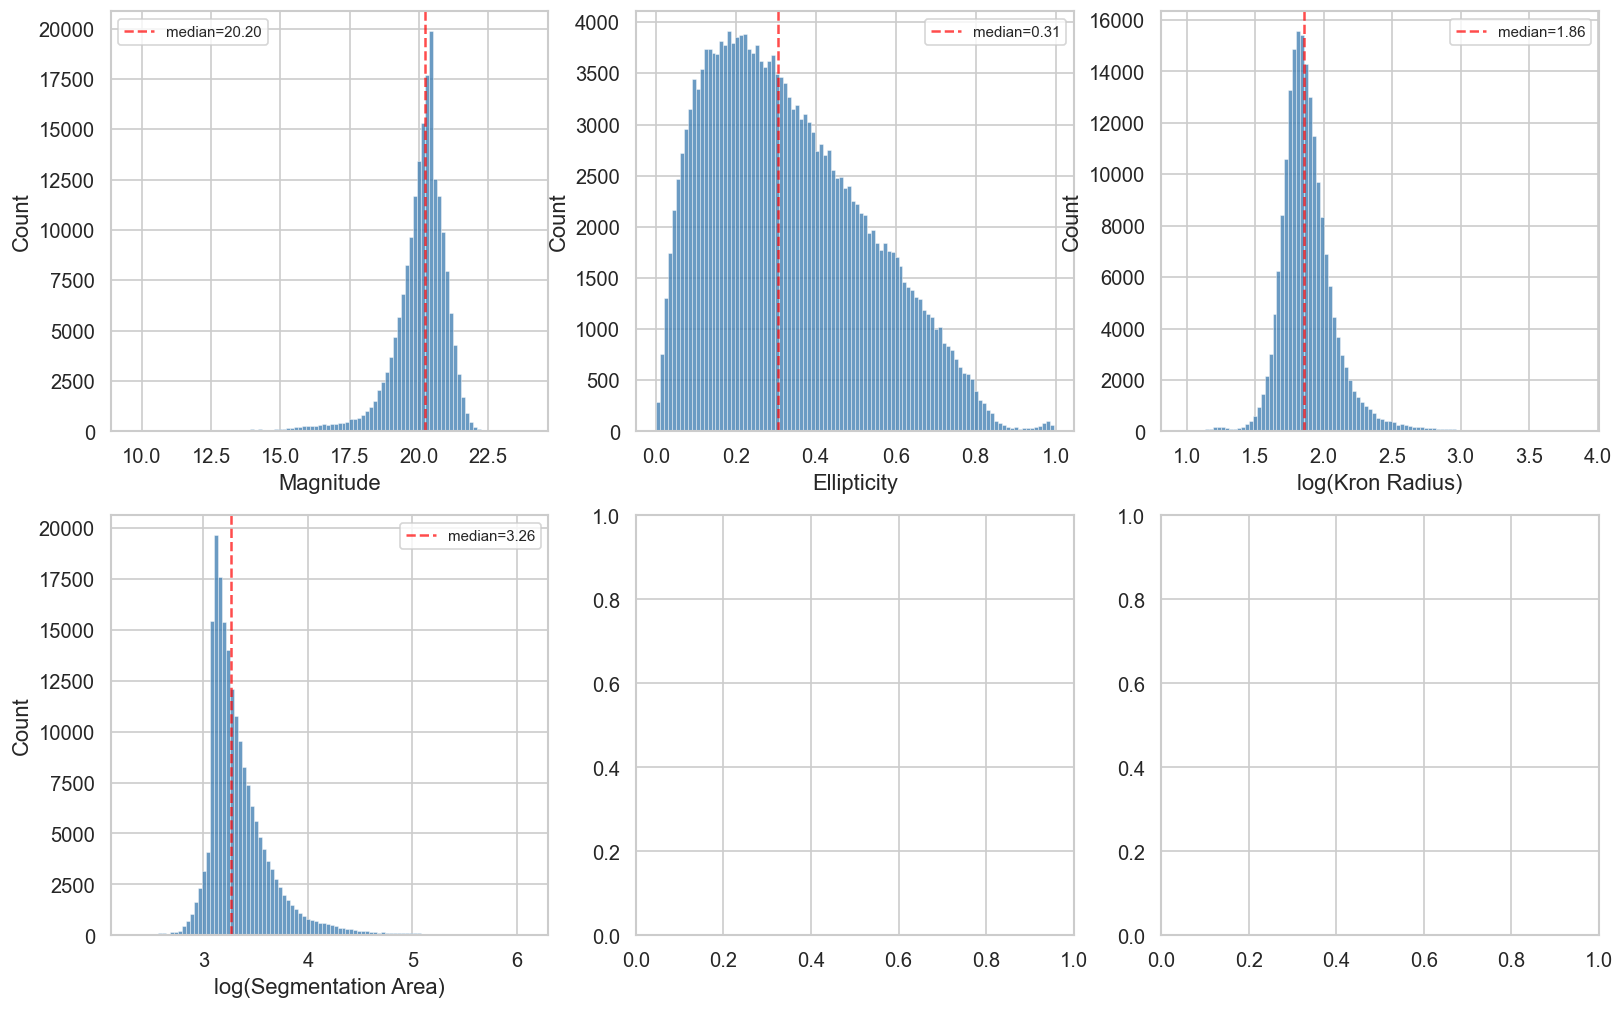

In [11]:
phys_cols = {
    'mag_segmentation': 'Magnitude',
    'ellipticity': 'Ellipticity',
    'log_kron_radius': 'log(Kron Radius)',
    'log_segmentation_area': 'log(Segmentation Area)',
    'mu_max': 'Peak Surface Brightness',
    'cutout_width_arcsec': 'Cutout Width (arcsec)',
}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, (col, label) in zip(axes.flat, phys_cols.items()):
    vals = df_good[col].dropna()
    ax.hist(vals, bins=100, color='steelblue', alpha=0.8, edgecolor='white', linewidth=0.3)
    ax.set_xlabel(label)
    ax.set_ylabel('Count')
    ax.axvline(vals.median(), color='red', linestyle='--', alpha=0.7, label=f'median={vals.median():.2f}')
    ax.legend(fontsize=9)

fig.suptitle('Physical Property Distributions (Good Galaxies)', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_physical_distributions.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Summary stats table
df_good[list(phys_cols.keys())].describe().round(3)

## 8. Sky Distribution

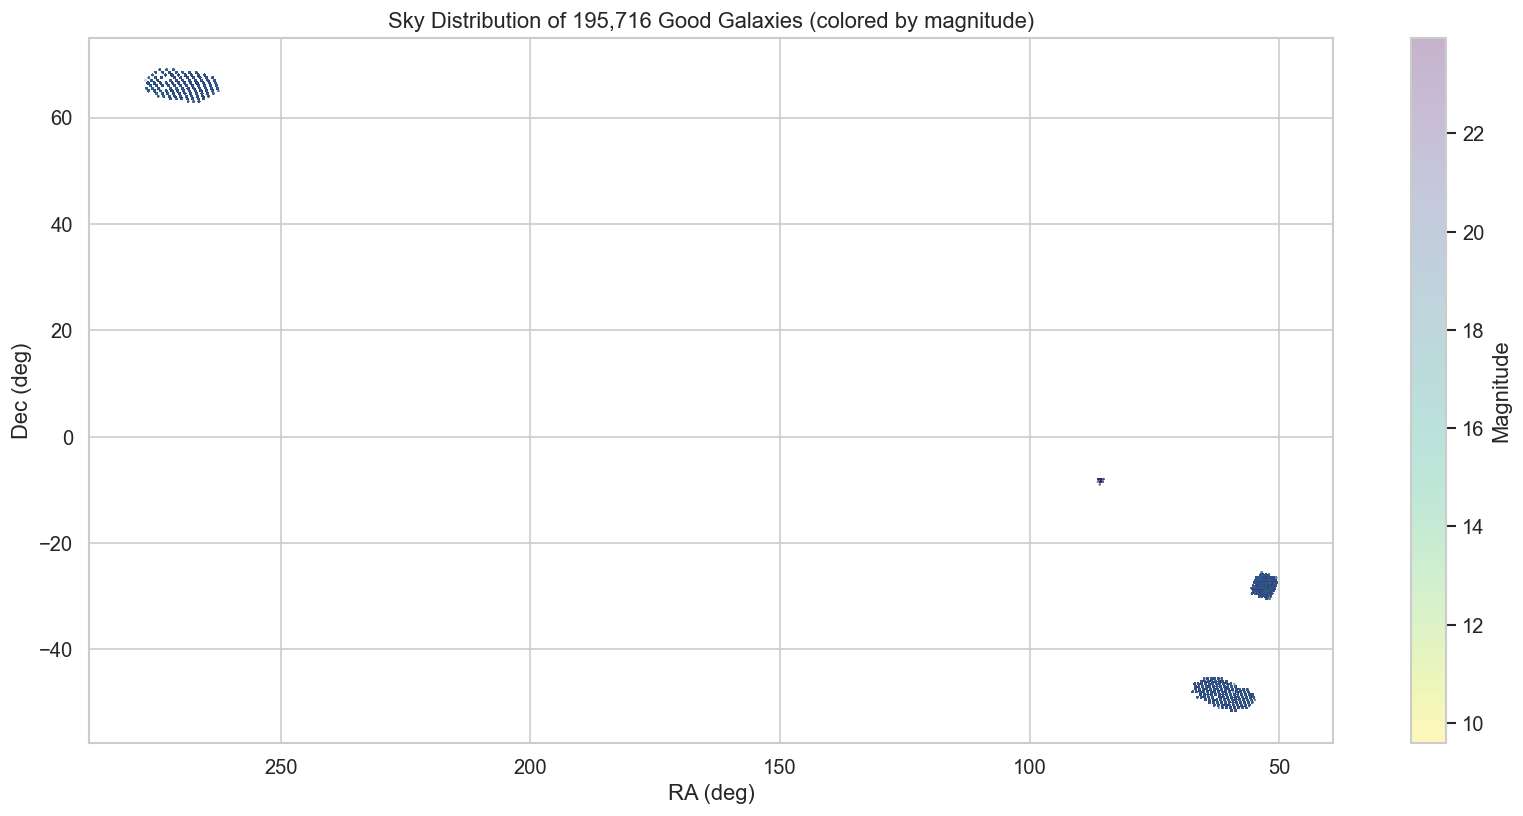

RA range:  50.50 to 277.12 deg
Dec range: -51.50 to 69.00 deg
Tiles: 342


In [12]:
fig, ax = plt.subplots(figsize=(14, 7))
scatter = ax.scatter(
    df_good['ra'], df_good['dec'],
    c=df_good['mag_segmentation'], cmap='viridis_r',
    s=0.1, alpha=0.3, rasterized=True
)
cbar = plt.colorbar(scatter, ax=ax, label='Magnitude')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'Sky Distribution of {len(df_good):,} Good Galaxies (colored by magnitude)')
ax.invert_xaxis()  # Astronomical convention
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_sky_distribution.pdf', bbox_inches='tight')
plt.show()

print(f'RA range:  {df_good["ra"].min():.2f} to {df_good["ra"].max():.2f} deg')
print(f'Dec range: {df_good["dec"].min():.2f} to {df_good["dec"].max():.2f} deg')
print(f'Tiles: {df_good["tile_index"].nunique()}')

## 9. Morphology vs Physical Properties

Do smooth and featured galaxies occupy different regions of physical property space?

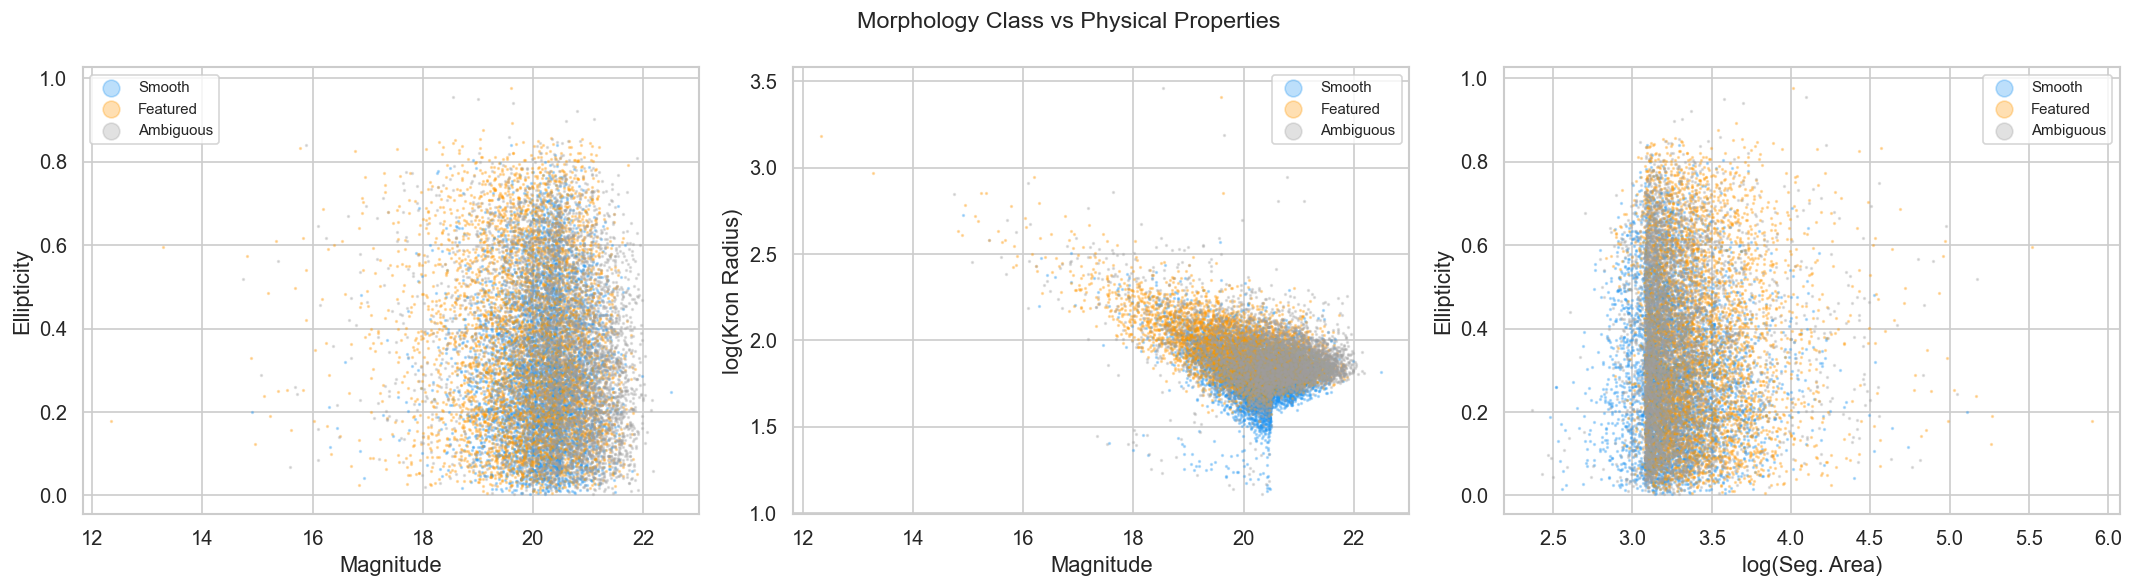

In [13]:
# Classify by dominant morphology
df_good = df_good.copy()
conditions = [
    df_good['smooth-or-featured_smooth_fraction'] > 0.5,
    df_good['smooth-or-featured_featured-or-disk_fraction'] > 0.5,
    df_good['smooth-or-featured_problem_fraction'] > 0.5,
]
choices = ['Smooth', 'Featured', 'Problem']
df_good['dominant_class'] = np.select(conditions, choices, default='Ambiguous')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_colors = {'Smooth': '#2196F3', 'Featured': '#FF9800', 'Problem': '#F44336', 'Ambiguous': '#9E9E9E'}

for ax, (x_col, y_col, xlabel, ylabel) in zip(axes, [
    ('mag_segmentation', 'ellipticity', 'Magnitude', 'Ellipticity'),
    ('mag_segmentation', 'log_kron_radius', 'Magnitude', 'log(Kron Radius)'),
    ('log_segmentation_area', 'ellipticity', 'log(Seg. Area)', 'Ellipticity'),
]):
    for cls in ['Smooth', 'Featured', 'Ambiguous']:
        mask = df_good['dominant_class'] == cls
        sub = df_good[mask].sample(n=min(5000, mask.sum()), random_state=42)
        ax.scatter(sub[x_col], sub[y_col], s=1, alpha=0.3,
                   color=class_colors[cls], label=cls, rasterized=True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(markerscale=10, fontsize=9)

fig.suptitle('Morphology Class vs Physical Properties', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_morphology_vs_physical.pdf', bbox_inches='tight')
plt.show()

## 10. Correlation Between Morphology Questions

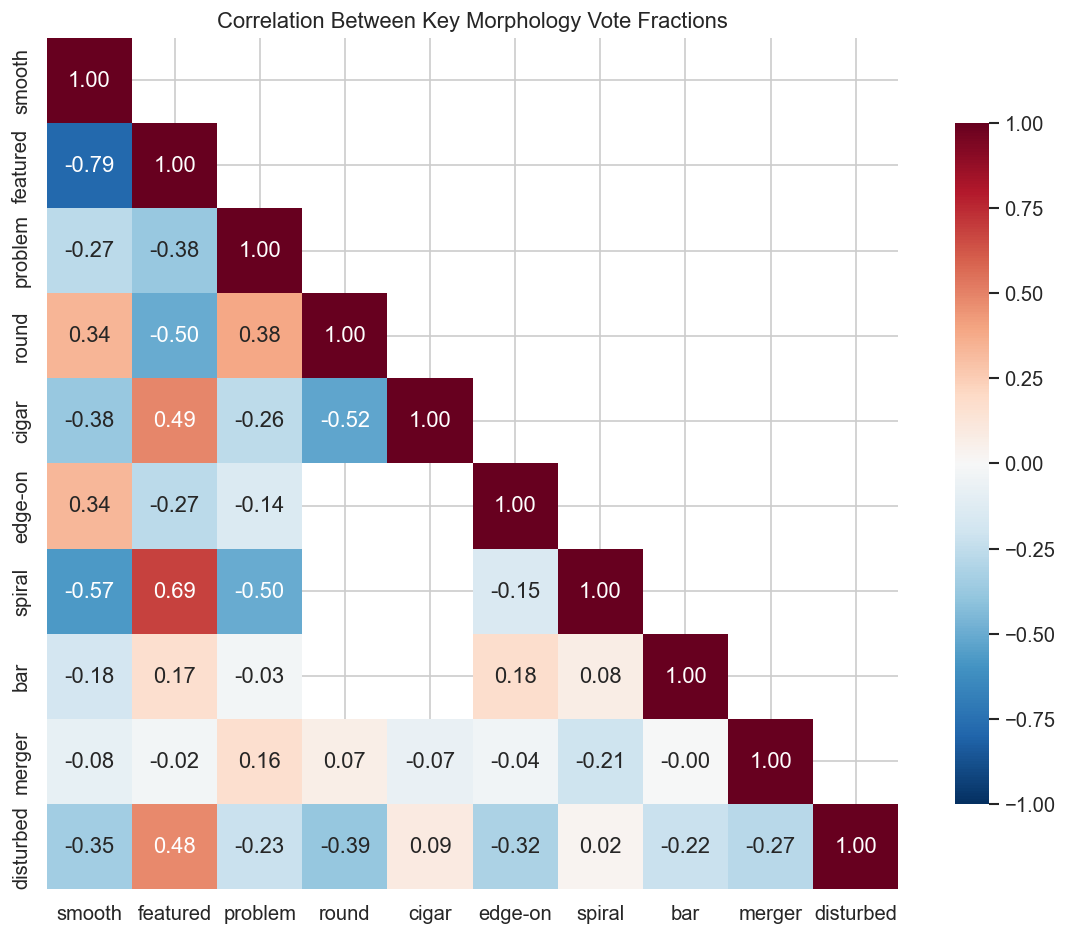

In [14]:
# Correlations between the main vote fractions
corr_cols = [
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_featured-or-disk_fraction',
    'smooth-or-featured_problem_fraction',
    'how-rounded_round_fraction',
    'how-rounded_cigar-shaped_fraction',
    'disk-edge-on_yes_fraction',
    'has-spiral-arms_yes_fraction',
    'bar_strong_fraction',
    'merging_merger_fraction',
    'merging_minor-disturbance_fraction',
]

# Short labels for readability
short_labels = [
    'smooth', 'featured', 'problem', 'round', 'cigar',
    'edge-on', 'spiral', 'bar', 'merger', 'disturbed'
]

corr_matrix = df_good[corr_cols].corr()
corr_matrix.columns = short_labels
corr_matrix.index = short_labels

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Between Key Morphology Vote Fractions')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_morphology_correlation.pdf', bbox_inches='tight')
plt.show()

## 11. Cutout Size Analysis

The cutout width varies per galaxy. We need to understand this for choosing input image size.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_good['cutout_width_arcsec'], bins=100, color='steelblue', alpha=0.8,
        edgecolor='white', linewidth=0.3)
ax.set_xlabel('Cutout Width (arcsec)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Galaxy Cutout Sizes')

# Key percentiles
for pct, color in [(25, '#4CAF50'), (50, '#FF9800'), (75, '#F44336'), (95, '#9C27B0')]:
    val = df_good['cutout_width_arcsec'].quantile(pct/100)
    ax.axvline(val, color=color, linestyle='--', alpha=0.8,
               label=f'P{pct}={val:.1f}"')

ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_cutout_sizes.pdf', bbox_inches='tight')
plt.show()

print('Cutout width percentiles (arcsec):')
print(df_good['cutout_width_arcsec'].describe().round(2))

## 12. Tile Distribution

Understanding the tile structure is important for preventing data leakage — nearby galaxies
on the same tile may share systematic effects. We may want to split by tile, not randomly.

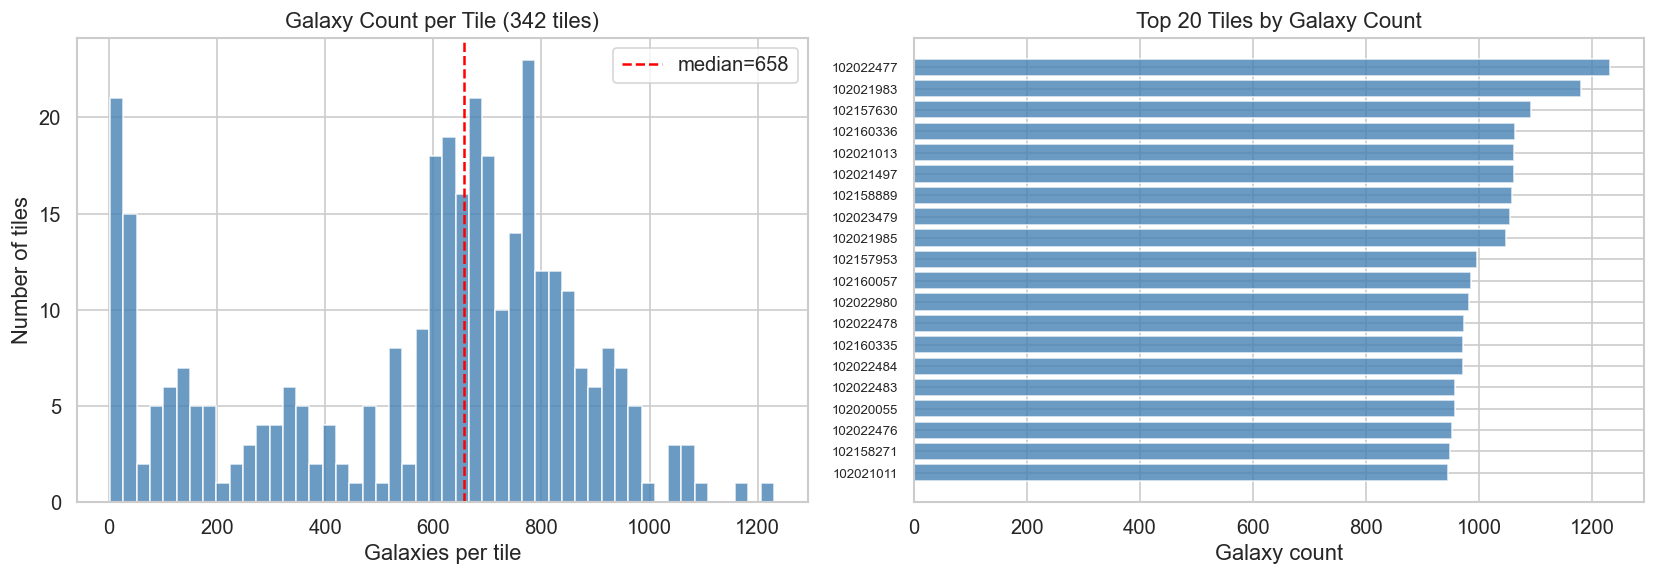

In [15]:
tile_counts = df_good['tile_index'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(tile_counts.values, bins=50, color='steelblue', alpha=0.8)
ax1.set_xlabel('Galaxies per tile')
ax1.set_ylabel('Number of tiles')
ax1.set_title(f'Galaxy Count per Tile ({len(tile_counts)} tiles)')
ax1.axvline(tile_counts.median(), color='red', linestyle='--',
            label=f'median={tile_counts.median():.0f}')
ax1.legend()

# Top 20 tiles
top20 = tile_counts.head(20)
ax2.barh(range(len(top20)), top20.values, color='steelblue', alpha=0.8)
ax2.set_yticks(range(len(top20)))
ax2.set_yticklabels(top20.index.astype(str), fontsize=8)
ax2.set_xlabel('Galaxy count')
ax2.set_title('Top 20 Tiles by Galaxy Count')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_tile_distribution.pdf', bbox_inches='tight')
plt.show()

## 13. Image Path Analysis

We need to understand the image naming convention to build our data pipeline.

In [16]:
# Examine the image path structure
print('=== Sample image paths ===')
print(f'\nVIS+Y JPG: {df_good["jpg_loc_gz_arcsinh_vis_y"].iloc[0]}')
print(f'\nVIS-only JPG: {df_good["jpg_loc_gz_arcsinh_vis_only"].iloc[0]}')
print(f'\nGeneric JPG: {df_good["jpg_loc_generic"].iloc[0]}')

# Extract filename pattern
sample_path = df_good['jpg_loc_gz_arcsinh_vis_y'].iloc[0]
parts = sample_path.split('/')
print(f'\n=== Path structure ===')
for i, part in enumerate(parts):
    print(f'  Level {i}: {part}')

# The tar files on Zenodo should contain these JPGs
# Let's figure out the expected filename format inside the tar
print(f'\n=== Filename format ===')
fname = parts[-1]
print(f'Filename: {fname}')
print(f'Pattern: <tile_index>_<object_id_with_NEG>_<type>.jpg')

=== Sample image paths ===

VIS+Y JPG: /media/home/team_workspaces/Euclid-Consortium/data/galaxy_zoo_euclid/v5_q1/mer_catalog_random_tiles_q1_full_gz/cutouts/jpg/gz_arcsinh_vis_y/102042913/102042913_NEG520559452289115027_gz_arcsinh_vis_y.jpg

VIS-only JPG: /media/home/team_workspaces/Euclid-Consortium/data/galaxy_zoo_euclid/v5_q1/mer_catalog_random_tiles_q1_full_gz/cutouts/jpg/gz_arcsinh_vis_only/102042913/102042913_NEG520559452289115027_gz_arcsinh_vis_only.jpg

Generic JPG: /media/home/team_workspaces/Euclid-Consortium/data/galaxy_zoo_euclid/v5_q1/mer_catalog_random_tiles_q1_full_gz/cutouts/jpg/generic/102042913/102042913_NEG520559452289115027_generic.jpg

=== Path structure ===
  Level 0: 
  Level 1: media
  Level 2: home
  Level 3: team_workspaces
  Level 4: Euclid-Consortium
  Level 5: data
  Level 6: galaxy_zoo_euclid
  Level 7: v5_q1
  Level 8: mer_catalog_random_tiles_q1_full_gz
  Level 9: cutouts
  Level 10: jpg
  Level 11: gz_arcsinh_vis_y
  Level 12: 102042913
  Level 13: 102

## 14. Summary & Recommendations for Next Steps

### Key Findings

In [17]:
print('=' * 60)
print('EUCLID Q1 MORPHOLOGY CATALOG — EDA SUMMARY')
print('=' * 60)
print(f'\nTotal galaxies:           {len(df):>10,}')
print(f'Good galaxies (training): {len(df_good):>10,}')
print(f'Flagged (excluded):       {n_flagged:>10,}')
print(f'Tiles:                    {df_good["tile_index"].nunique():>10}')
print(f'\n--- Dominant Morphology (good galaxies) ---')
for cls, count in zip(labels, counts):
    print(f'  {cls:15s}: {count:>8,} ({count/len(df_good)*100:.1f}%)')
print(f'\n--- Target Questions for Regression ---')
print(f'  smooth-or-featured:  {len(df_good):,} (all good galaxies)')
print(f'  merging:             {len(df_good):,} (all good galaxies)')
feat_good = df_good['disk-edge-on_yes_fraction'].notna().sum()
spiral_good = df_good['has-spiral-arms_yes_fraction'].notna().sum()
print(f'  disk-edge-on:        {feat_good:,} (featured branch)')
print(f'  has-spiral-arms:     {spiral_good:,} (non-edge-on featured)')
print(f'\n--- Magnitude Range ---')
print(f'  Min: {df_good["mag_segmentation"].min():.1f}')
print(f'  Max: {df_good["mag_segmentation"].max():.1f}')
print(f'  Median: {df_good["mag_segmentation"].median():.1f}')
print(f'\n--- Recommendations ---')
print(f'  1. Use ~195K good galaxies for training')
print(f'  2. Predict all vote fractions simultaneously')
print(f'  3. Handle NaN targets with masked loss (tree-structured)')
print(f'  4. Consider tile-aware splits to avoid spatial leakage')
print(f'  5. Download cutouts_jpg_gz_arcsinh_vis_y.tar (3.8 GB)')
print(f'     for VIS+Y-band images as primary training data')
print('=' * 60)

EUCLID Q1 MORPHOLOGY CATALOG — EDA SUMMARY

Total galaxies:              380,111
Good galaxies (training):    195,716
Flagged (excluded):          184,395
Tiles:                           342

--- Dominant Morphology (good galaxies) ---
  Smooth         :   89,095 (45.5%)
  Featured/Disk  :   81,030 (41.4%)
  Problem        :    9,763 (5.0%)
  Ambiguous      :   15,828 (8.1%)

--- Target Questions for Regression ---
  smooth-or-featured:  195,716 (all good galaxies)
  merging:             195,716 (all good galaxies)
  disk-edge-on:        81,108 (featured branch)
  has-spiral-arms:     61,603 (non-edge-on featured)

--- Magnitude Range ---
  Min: 9.6
  Max: 23.9
  Median: 20.2

--- Recommendations ---
  1. Use ~195K good galaxies for training
  2. Predict all vote fractions simultaneously
  3. Handle NaN targets with masked loss (tree-structured)
  4. Consider tile-aware splits to avoid spatial leakage
  5. Download cutouts_jpg_gz_arcsinh_vis_y.tar (3.8 GB)
     for VIS+Y-band images a

### Next Steps

1. **`02_data_preparation.ipynb`**: Download image cutouts, build PyTorch Dataset with stratified splits
2. **`src/data/`**: Implement `EuclidDataset` class with masking for tree-structured targets
3. **`configs/base.yaml`**: Define base training configuration

### Key Design Decisions from EDA

| Decision | Rationale |
|---|---|
| Use `warning_galaxy_fails_training_cuts` filter | Nearly half the catalog is flagged — use same cuts as Zoobot |
| Predict all questions simultaneously | Matches Zoobot; use masked loss for NaN targets |
| Use VIS+Y images (`cutouts_jpg_gz_arcsinh_vis_y`) | Multi-band input gives ViTs more spectral information |
| Consider tile-aware data splits | Prevent spatial leakage between train/val/test |